In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import yt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.colors import LogNorm
import os,sys

from galaxy_analysis.static_data import SOLAR_ABUNDANCE

# galaxy analysis methods (for comparison)
from galaxy_analysis.gizmo import yield_model
from galaxy_analysis.utilities import cy_convert_abundances as ca
from galaxy_analysis.plot.plot_styles import *
#--------------

# gizmo analysis methods 
import gizmo_analysis as gizmo
import utilities as gizmo_ut
from utilities.basic.binning import BinClass

#------------------------------
input_type = 'mass'

def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return

plot_settings()

In [2]:
0.0001 * 10**(SOLAR_ABUNDANCE["Fe"] - SOLAR_ABUNDANCE["H"])

3.1622776601683795e-09

In [3]:
initial_part['gas'].prop('massfraction.metals')

NameError: name 'initial_part' is not defined

In [9]:
simulation = 'm12q'
wdir = "/home/aemerick/work/gizmo_runs/m10q_res130000/"
wdir = "/home/aemerick/work/gizmo_runs/m12q_res5700_test/"

initial_part = gizmo.io.Read.read_snapshots(['gas'],'index',0,simulation_directory=wdir)
initial = {}
for e in ['H','He','C','N','O','Ne','Mg','Si','S','Ca','Fe']:
    initial[str.lower(e)] = np.average(initial_part['gas'].prop('massfraction.' + str.lower(e)))
initial['metals'] = np.average(initial_part['gas'].prop('massfraction.metals'))
#
#
#
#
#
    
    
sim_index = 342

# load the data set
part = gizmo.io.Read.read_snapshots(['dark','star','gas'], 'index', sim_index,
                                    #assign_host_principal_axes=True, 
                                    simulation_directory = wdir)
part2 = gizmo.io.Read.read_snapshots(['dark','star','gas'], 'index', sim_index,
                                    #assign_host_principal_axes=True, 
                                    simulation_directory = wdir)


FIRE2_model =  gizmo.agetracers.FIRE2_yields(model_Z = 0.5, Z_scaling = True)
yield_table =  gizmo.agetracers.construct_yield_table(FIRE2_model, 
                                                      part.ageprop.age_bins/1000.0)


NuGrid_model       = gizmo.agetracers.NuGrid_yields(iniZ = 0.01, imf_type = 'kroupa')
NuGrid_yield_table = gizmo.agetracers.construct_yield_table(NuGrid_model,
                                                            part.ageprop.age_bins/1000.0)

part.set_yield_table(yield_table, FIRE2_model.elements)
part.set_initial_abundances(initial)
part2.set_yield_table(NuGrid_yield_table, [str.lower(x) for x in NuGrid_model.elements])
part2.set_initial_abundances(initial)

#part.set_initial_abundances()
# 

               
ds = yt.load(wdir + '/output/snapshot_%03i.hdf5'%(sim_index))
data = ds.all_data()


# in utilities.simulation.Snapshot():
* reading:  home/aemerick/work/gizmo_runs/m12q_res5700_test/snapshot_times.txt

  using snapshot index = 0, redshift = 99.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/aemerick/work/gizmo_runs/m12q_res5700_test/output/snapshot_000.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 16220880 particles
    dark2     (id = 2): 4132251 particles
    gas       (id = 0): 16220880 particles
    star      (id = 4): 0 particles
    blackhole (id = 5): 0 particles

* reading species: ['gas']
* reading gas properties: ['acceleration', 'density', 'electron.fraction', 'hydrogen.neutral.fraction', 'id', 'id.child', 'id.generation', 'mass', 'massfraction', 'position', 'potential', 'sfr', 'smooth.length', 'temperature', 'velocity']
* reading particles from:
    home/aemerick/work/gizmo_runs/m12q_res5700_test/output/snapshot_000.hdf5

! cannot find MUSIC config file:  home/aemerick/work/gizmo_runs/m12q_res5

In [4]:
gas_O = part['gas'].prop('mass.n') - np.min(part['gas'].prop('mass.n'))
select_enriched = gas_O > 0
age_O = part['gas'].prop('mass.agetracer.n')

np.size(gas_O[select_enriched])

13934176

In [6]:
part._initial_abundances

{'metals': 0.0,
 'helium': 0.25000048,
 'he': 0.25000048,
 'carbon': 3.2600323e-07,
 'c': 3.2600323e-07,
 'nitrogen': 1.3199946e-07,
 'n': 1.3199946e-07,
 'oxygen': 8.6499114e-07,
 'o': 8.6499114e-07,
 'neon': 2.2200248e-07,
 'ne': 2.2200248e-07,
 'magnesium': 9.3102e-08,
 'mg': 9.3102e-08,
 'silicon': 1.08001146e-07,
 'si': 1.08001146e-07,
 'sulphur': 6.43999e-08,
 's': 6.43999e-08,
 'calcium': 1.01001625e-08,
 'ca': 1.01001625e-08,
 'iron': 1.7299575e-07,
 'fe': 1.7299575e-07}


# in utilities.basic.binning.get_bin_indices():
! input value limits = [-3.87, 0.85] exceed bin limits = [-3.87, 0.85]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [-3.87, 0.92] exceed bin limits = [-3.87, 0.92]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [-3.87, -0.67] exceed bin limits = [-3.87, -0.67]


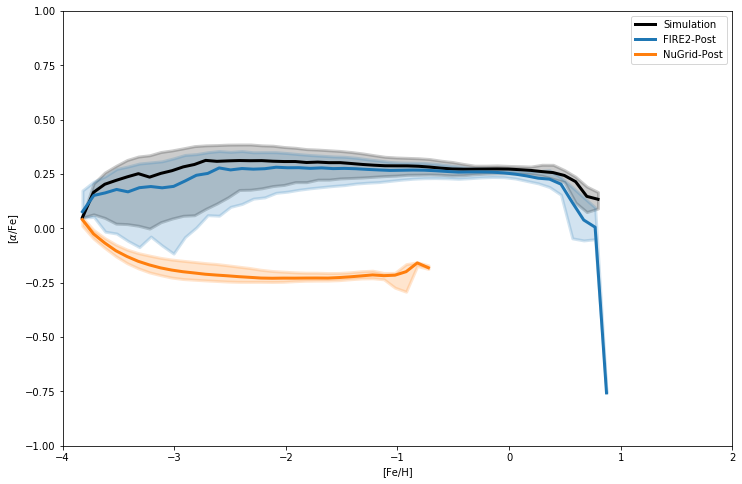

In [10]:
#
#
# lets make a cool plot
#
#

fig, ax = plt.subplots()
fig.set_size_inches(12,8)


def get_abundance(p, e1,e2, agetracer=False):
    prefix = 'metallicity'
    if agetracer:
        prefix = prefix + '.agetracer'
    if e2 != 'h':
        propname = prefix + '.' + e1 + ' - ' + prefix + '.' + e2
    else:
        propname = prefix + '.' + e1
    return p.prop(propname)
    

def lineplot(_ax, xvals, yvals, **kwargs):
    
    valmin = np.max([-8,np.min( xvals)])
    valmax = np.max(xvals)
    
    bc    = BinClass([valmin,valmax],number= int((valmax-valmin)/0.1))
    stats = bc.get_statistics_of_array(xvals,yvals)
    
    
    
    _ax.plot(stats['bin.mid'], stats['median'], lw = 3, **kwargs)
    
    fill_kwargs = kwargs
    if 'label' in fill_kwargs:
        del fill_kwargs['label']
    
    _ax.fill_between(stats['bin.mid'], stats['percent.16'], stats['percent.84'], alpha=0.2,
                     lw = 3, **fill_kwargs)
    
    #print(stats['bin.mid'])
    return
    
    
lineplot(ax, get_abundance(part['star'],'fe','h'), get_abundance(part['star'],'alpha','fe'),
             color = 'black', label="Simulation")
lineplot(ax, get_abundance(part['star'],'fe','h',True), get_abundance(part['star'],'alpha','fe',True),
             color = 'C0', label="FIRE2-Post")
lineplot(ax, get_abundance(part2['star'],'fe','h',True), get_abundance(part2['star'],'alpha','fe',True),
             color = 'C1', label="NuGrid-Post")

ax.set_xlim(-4,2)
ax.set_ylim(-1,1)

ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")

ax.legend(loc='best')

In [11]:
np.max(get_abundance(part2['star'],'fe','h',True))

-0.8365865280702908


# in utilities.basic.binning.get_bin_indices():
! input value limits = [-3.87, 0.85] exceed bin limits = [-3.87, 0.85]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [-3.87, 0.92] exceed bin limits = [-3.87, 0.92]

# in utilities.basic.binning.get_bin_indices():
! input value limits = [-3.87, -0.67] exceed bin limits = [-3.87, -0.67]


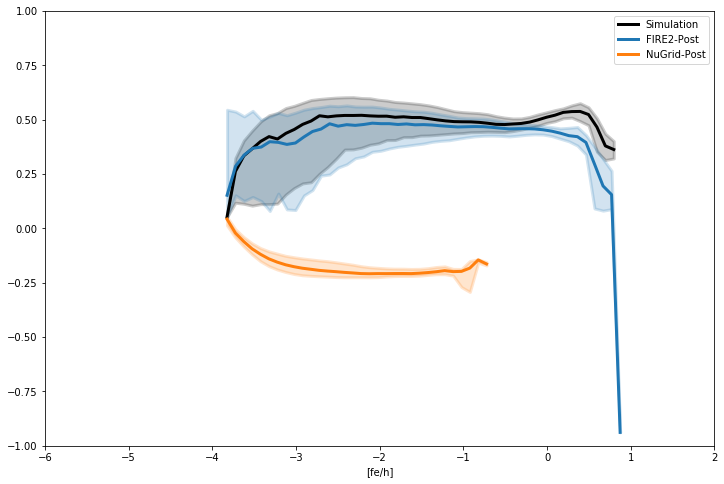

In [11]:
#
#
# lets make a cool plot
#
#

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ye1,ye2 = 'o','fe'
xe1,xe2 = 'fe','h'
    
lineplot(ax, get_abundance(part['star'],xe1,xe2), get_abundance(part['star'],ye1,ye2),
             color = 'black', label="Simulation")
lineplot(ax, get_abundance(part['star'],xe1,xe2,True), get_abundance(part['star'],ye1,ye2,True),
             color = 'C0', label="FIRE2-Post")
lineplot(ax, get_abundance(part2['star'],xe1,xe2,True), get_abundance(part2['star'],ye1,ye2,True),
             color = 'C1', label="NuGrid-Post")

ax.set_xlim(-6,2)
ax.set_ylim(-1,1)

ax.set_xlabel(r"[" + ye1 + "/" + ye2 +"]")
ax.set_xlabel(r"[" + xe1 + "/" + xe2 +"]")

ax.legend(loc='best')

In [15]:
np.min(part['star'].prop('metallicity.agetracer.fe'))

-inf

In [ ]:
print(mass)
print(np.sum(x * y, axis=1))

In [6]:
#
# How to generate yields:
#

age_bins = yield_model.get_bins(config_file = wdir + "/gizmo.out", binfile = wdir+"/age_bins.txt")

Z = 0.0002
FIRE_Z_scaling = True
age_is_fraction = True

total_yields = yield_model.construct_yields(age_bins/1000.0, # pass bins as Gyr, Z = Z,
                                    Z = Z, yieldtype = 'total', FIRE_Z_scaling=FIRE_Z_scaling)
ds0     = yt.load(wdir + 'output/snapshot_000.hdf5')
data0   = ds0.all_data()
fields = ds0.field_list

# generate
yield_model.generate_metal_fields(ds0,_agebins=age_bins,_yields=total_yields, age_is_fraction=age_is_fraction)
#yield_model._generate_star_metal_fields(ds0, _agebins = age_bins, _yields = total_yields)

metals = np.unique([x[1] for x in ds0.field_list if ((x[0] == 'PartType0') and ('Metal' in x[1]))])

initial_abundance=np.zeros(15)
for i in np.arange(np.size(initial_abundance)):
    z = data0[('PartType0','Metallicity_%02i'%(i))]
    #print("%5.5E %5.5E %5.5E"%(np.min(z),np.max(z),np.average(z)))

    initial_abundance[i] = np.average(z).value
    
    #print(np.min(z).value,np.average(z).value,np.max(z).value)
    
logH = np.log10(ds0.hubble_constant)
ds     = yt.load(wdir + 'output/snapshot_%003i.hdf5'%(sim_index))
data   = ds.all_data()
fields = ds.field_list

# generate
yield_model.generate_metal_fields(ds,_agebins=age_bins,_yields=total_yields,age_is_fraction=age_is_fraction)
yield_model._generate_star_metal_fields(ds, _agebins = age_bins, _yields = total_yields,age_is_fraction=age_is_fraction)

ptypes = np.unique([x[0] for x in ds.field_list])
metals = np.unique([x[1] for x in ds.field_list if ((x[0] == 'PartType0') and ('Metal' in x[1]))])
# load ds and generate yields

N yield in SNII is less than zero due to FIRE scaling
N yield in SNIA is negative
Total O yield in winds is negative due to Z scaling


In [ ]:
yt_answer = data[('all','PartType4_O_mass')]
pm = part['star'].prop('mass')

In [ ]:
yt_answer.value #+ initial_abundance[4] * pm

In [ ]:
O - initial_abundance[4]*pm

In [ ]:
part['star'].prop('agetracer.mass.o')

In [ ]:
mass / yt_answer.value

In [ ]:
1/(part['star'].prop('mass') / (mass/yt_answer.value))

In [ ]:
#for i in np.arange(16):
    #print(np.abs((total_yields[:,i]-yield_table[:,i]) / (total_yields[:,i])))

In [ ]:
yield_table[:,4]

In [ ]:
yield_model.construct_yields?

In [ ]:
age_bins

In [ ]:
FIRE2_model.snII_yields

In [ ]:
data[('PartType4','Metallicity_30')]

In [ ]:
part['star']['massfraction'][:,30]

In [ ]:
part['star']['massfraction'][:,30]

In [ ]:
part['star']['mass'] / 1.0E10